In [1]:
import mne
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import signal
from matplotlib.pyplot import figure
import scipy.signal
import neurokit2 as nk
import plotly.express as px
from shapely.geometry import Polygon
import plotly.graph_objects as go
from PIL import Image
from tqdm import tqdm

from func import *

# СОЗДАНИЕ ДАТАСЕТА ИЗОБРАЖЕНИЙ:

Генерация проекций:

In [2]:
path_dataset = '../dataset/Dataset_larger_1250/FULL_DATA'
for num in [2,3,4,5,6,7,8]:
    print('Период номер', num)
    for filename in tqdm(os.listdir(path_dataset)):
        if filename.endswith('.edf'):  # Фильтр по типу файлов
            file_path = os.path.join(path_dataset, filename)
            input ={}
            input["data_edf"] = file_path
            input["n_term_start"] = num
            input["n_term_finish"] = None
            input["filt"] = True
            input["f_sreza"] = 0.7
            input["f_sampling"] = 2000
            input["show_detected_pqrst"] = False
            input["show_ecg"] = False
            input["plot_3d"] = False
            input["save_images"] = True
            input["show_log_scaling"] = False
            input["cancel_showing"] = True
            input["qrs_loop_area"] = False
            input["t_loop_area"] = False
            input["show_log_loop_area"] = False
            input["count_qrst_angle"] = False
            input["show_log_qrst_angle"] = False
            input["save_coord"] = False
            input["mean_filter"] = False
            res = processing(input)

Период номер 3


100%|██████████| 342/342 [01:20<00:00,  4.23it/s]


Период номер 4


100%|██████████| 342/342 [01:18<00:00,  4.38it/s]


Период номер 5


100%|██████████| 342/342 [01:18<00:00,  4.36it/s]


Период номер 6


100%|██████████| 342/342 [01:17<00:00,  4.40it/s]


Период номер 7


100%|██████████| 342/342 [01:45<00:00,  3.24it/s]


Период номер 8


100%|██████████| 342/342 [01:16<00:00,  4.46it/s]


Период номер 9


100%|██████████| 342/342 [01:12<00:00,  4.73it/s]


Объединение в трехканальное изображение:

In [4]:
# Путь к основной папке
main_folder = 'saved_vECG'

# Создайте папку для сохранения цветных изображений
output_folder = 'dataset_RGB'
os.makedirs(output_folder, exist_ok=True)

for filename in tqdm(os.listdir('saved_vECG/XZ_plane')):
    if filename.endswith('.png'):  # Фильтр по типу файлов
        
        # Откройте изображения R, G и B
        r_image = Image.open(os.path.join(main_folder, 'XZ_plane', filename)).convert("L")
        g_image = Image.open(os.path.join(main_folder, 'XY_plane', filename)).convert("L")
        b_image = Image.open(os.path.join(main_folder, 'YZ_plane', filename)).convert("L")

        # Создайте цветное изображение RGB
        color_image = Image.merge('RGB', (r_image, g_image, b_image))

        # Сохраните цветное изображение в новой папке
        output_path = os.path.join(output_folder, filename)
        color_image.save(output_path)

print("Объединение каналов завершено!")


100%|██████████| 2332/2332 [01:57<00:00, 19.87it/s]

Объединение каналов завершено!


Разделение на train/val:

In [4]:
data ={}
data["folder_dataset"] = 'dataset_RGB'
data["folder_save_csv"] = 'csv_folder'
data["auto_split"] = True
data["percent_error"] = 2
data["percent_train"] = 75
get_csv(data)

CSV таблица сохранена в папке csv_folder

Всего имеется 2269 кропов.
Для реализации пропорции 75/25 необходимо в файле csv_folder/info_dataset.csv отнести на валидацию (val) примерно 567 кропов.

Выбран режим автоматического сплитования:
Условие рандомной генерации +-2% от требуемого 567 числа кропов на валидацию - [556,578]

В результате автоматического сплитования получилось отнести на валидацию 558 кропов
Итоговое соотношение train/val = 75/25


In [5]:
data = {}
data["dataset_path"] = 'dataset_RGB'
data["splitted_dataset_name"] = 'final_img_dataset'
data["csv_folder"] = 'csv_folder'
data["excel_file"] = '..\dataset\explication.xlsx'
split(data)

Cоздано следующее число изображений:
На train - 1711
На val - 558 

Итоговое соотношение train/val = 75/25

Разделенный датасет расположен в папке final_img_dataset


---

# СОЗДАНИЕ POINTCLOUD ДАТАСЕТА:

In [2]:
path_dataset = '../dataset/Dataset_larger_1250/FULL_DATA'
total_shapes = []
for num in [2,3,4,5,6,7,8]:
    print('Период номер', num)
    shapes = []
    for filename in tqdm(os.listdir(path_dataset)):
        if filename.endswith('.edf'):  # Фильтр по типу файлов
            file_path = os.path.join(path_dataset, filename)
            input ={}
            input["data_edf"] = file_path
            input["n_term_start"] = num
            input["n_term_finish"] = None
            input["filt"] = True
            input["f_sreza"] = 0.7
            input["f_sampling"] = 700
            input["show_detected_pqrst"] = False
            input["show_ecg"] = False
            input["plot_3d"] = False
            input["save_images"] = False
            input["show_log_scaling"] = False
            input["cancel_showing"] = True
            input["qrs_loop_area"] = False
            input["t_loop_area"] = False
            input["show_log_loop_area"] = False
            input["count_qrst_angle"] = False
            input["show_log_qrst_angle"] = False
            input["save_coord"] = True
            input["mean_filter"] = False
            res = processing(input)
            shapes.append(res)
    total_shapes.append(shapes)

Период номер 2


 27%|██▋       | 332/1250 [00:34<01:45,  8.74it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [02:06<00:00,  9.91it/s]


Период номер 3


 26%|██▋       | 331/1250 [00:29<01:22, 11.20it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [01:50<00:00, 11.34it/s]


Период номер 4


 27%|██▋       | 332/1250 [00:29<01:27, 10.46it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [01:49<00:00, 11.37it/s]


Период номер 5


 27%|██▋       | 332/1250 [00:31<01:26, 10.57it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [01:57<00:00, 10.68it/s]


Период номер 6


 27%|██▋       | 332/1250 [00:31<01:30, 10.12it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [02:12<00:00,  9.46it/s]


Период номер 7


 27%|██▋       | 332/1250 [00:30<01:27, 10.43it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [01:55<00:00, 10.83it/s]


Период номер 8


 27%|██▋       | 332/1250 [00:28<01:25, 10.73it/s]

На I отведении не удалось детектировать R зубцы
Проводим детектирование по II отведению:


100%|██████████| 1250/1250 [01:49<00:00, 11.42it/s]


Распределение числа точек в датасете для каждого пациента:

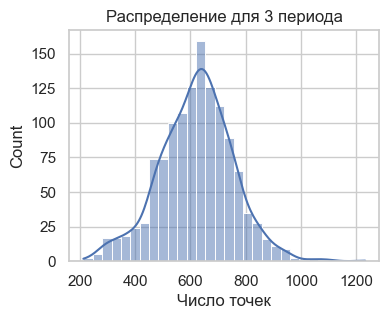

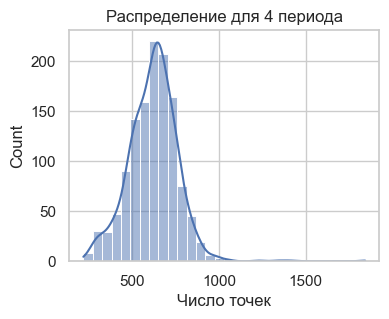

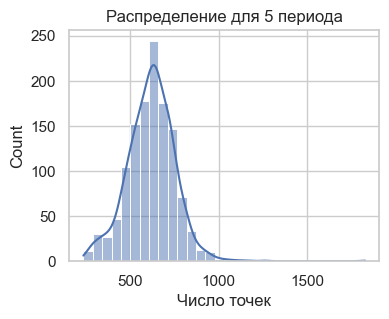

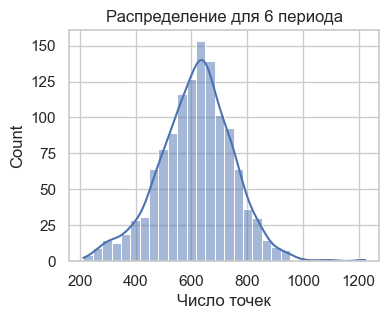

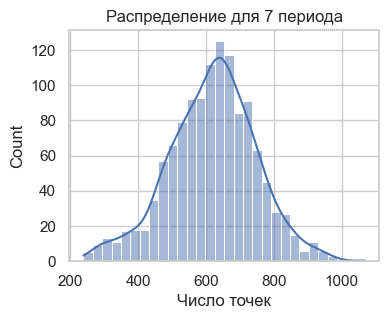

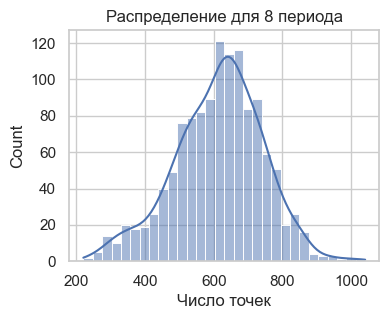

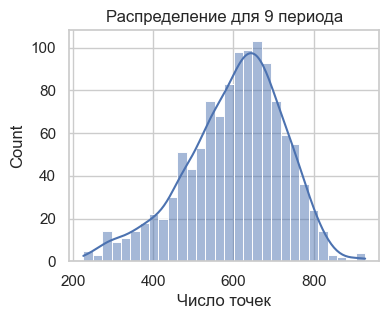

In [3]:
import seaborn as sns

for i in range(len(total_shapes)):
    sns.set(style="whitegrid")
    plt.figure(figsize=(4, 3))
    sns.histplot(x=total_shapes[i], kde=True, bins=30)
    plt.title(f"Распределение для {[3,4,5,6,7,8,9][i]} периода")
    plt.xlabel("Число точек")
    plt.show()

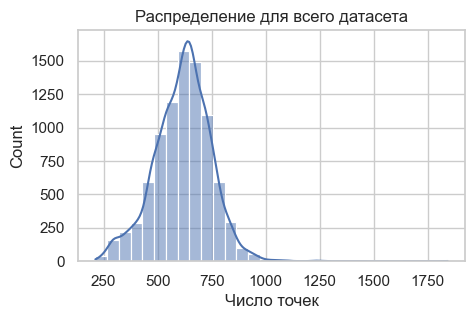

In [4]:
n_points = []
for num in total_shapes:
    n_points.extend(num)
sns.set(style="whitegrid")
plt.figure(figsize=(5, 3))
sns.histplot(x=n_points, kde=True, bins=30)
plt.title(f"Распределение для всего датасета")
plt.xlabel("Число точек")
plt.show()


In [5]:
data ={}
data["folder_dataset"] = 'point_cloud_dataset'
data["folder_save_csv"] = 'csv_folder_point_cloud'
data["auto_split"] = True
data["percent_error"] = 2
data["percent_train"] = 75
get_csv(data)

CSV таблица сохранена в папке csv_folder_point_cloud

Всего имеется 8671 кропов.
Для реализации пропорции 75/25 необходимо в файле csv_folder_point_cloud/info_dataset.csv отнести на валидацию (val) примерно 2167 кропов.

Выбран режим автоматического сплитования:
Условие рандомной генерации +-2% от требуемого 2167 числа кропов на валидацию - [2124,2210]

В результате автоматического сплитования получилось отнести на валидацию 2125 кропов
Итоговое соотношение train/val = 75/25


In [12]:
df = pd.read_excel('../dataset/1250_ef.xlsx')

def func_change(value):
    return value[:-4]

df['FileID'] = df.File.apply(func_change)
df.to_excel('../dataset/1250_ef.xlsx', index=False)
df

,File,EF,FileID
0,AG1.edf,68,AG1
1,AG10.edf,60,AG10
2,AG100.edf,65,AG100
3,AG101.edf,72,AG101
4,AG102.edf,70,AG102
...,...,...,...
1245,IOMI95.edf,65,IOMI95
1246,IOMI96.edf,38,IOMI96
1247,IOMI97.edf,54,IOMI97
1248,IOMI98.edf,67,IOMI98


In [2]:
data = {}
data["dataset_path"] = 'point_cloud_dataset'
data["splitted_dataset_name"] = 'final_pointcloud_dataset'
data["csv_folder"] = 'csv_folder_point_cloud'
data["excel_file"] = '../dataset/1250_ef.xlsx'
split(data)

Cоздано следующее число изображений:
На train - 6546
На val - 2125 

Итоговое соотношение train/val = 75/25

Разделенный датасет расположен в папке final_pointcloud_dataset


__Так же сформируем датасет нормализованных точек:__

In [6]:
data ={}
data["folder_dataset"] = 'point_cloud_dataset_normalized'
data["folder_save_csv"] = 'csv_folder_point_cloud_normalized'
data["auto_split"] = True
data["percent_error"] = 2
data["percent_train"] = 75
get_csv(data)

CSV таблица сохранена в папке csv_folder_point_cloud_normalized

Всего имеется 2335 кропов.
Для реализации пропорции 75/25 необходимо в файле csv_folder_point_cloud_normalized/info_dataset.csv отнести на валидацию (val) примерно 583 кропов.

Выбран режим автоматического сплитования:
Условие рандомной генерации +-2% от требуемого 583 числа кропов на валидацию - [571,595]

В результате автоматического сплитования получилось отнести на валидацию 574 кропов
Итоговое соотношение train/val = 75/25


In [7]:
data = {}
data["dataset_path"] = 'point_cloud_dataset_normalized'
data["splitted_dataset_name"] = 'final_pointcloud_dataset_normalized'
data["csv_folder"] = 'csv_folder_point_cloud_normalized'
data["excel_file"] = '..\dataset\explication.xlsx'
split(data)

Cоздано следующее число изображений:
На train - 1761
На val - 574 

Итоговое соотношение train/val = 75/25

Разделенный датасет расположен в папке final_pointcloud_dataset_normalized


---

# Генерация данных для классического ML (feature extraction):

In [7]:
path_dataset = '../dataset/EDF EF/'
n_error = 0
n_ok = 0

columns = ['File', 'Square_QRS_frontal', 'Square_QRS_sagittal','Square_QRS_axial',
           'Square_ST_frontal', 'Square_ST_sagittal','Square_ST_axial',
           'Angle_QRST', 'Frontal_Angle_QRST']
results_df = pd.DataFrame(columns=columns)

for num in [4]:
    print('Период номер', num)
    for filename in tqdm(os.listdir(path_dataset)):
        if filename.endswith('.edf'):  # Фильтр по типу файлов
            file_path = os.path.join(path_dataset, filename)
            input ={}
            input["data_edf"] = file_path
            input["n_term_start"] = num
            input["n_term_finish"] = None
            input["filt"] = True
            input["f_sreza"] = 0.7
            input["f_sampling"] = 700
            input["show_detected_pqrst"] = False
            input["show_ecg"] = False
            input["plot_3d"] = False
            input["save_images"] = False
            input["show_log_scaling"] = False
            input["cancel_showing"] = True
            input["qrs_loop_area"] = True
            input["t_loop_area"] = True
            input["show_log_loop_area"] = False
            input["count_qrst_angle"] = True
            input["show_log_qrst_angle"] = False
            input["save_coord"] = False
            input["mean_filter"] = False
            try:
                list_square, angle, project_angle = processing(input)
                # Создание строки с результатами
                row = [file_path.split('/')[-1], list_square[0], list_square[1], 
                       list_square[2], list_square[3], list_square[4],
                       list_square[5], angle, project_angle]
                
                # Добавление строки в DataFrame
                results_df.loc[len(results_df)] = row
                n_ok += 1
            except:
                n_error += 1

                
# Сохранение результатов в CSV файл
results_csv_filename = 'all_data_for_ml.csv'
results_df.to_csv(results_csv_filename, index=False)

print(f"Успешно обработано файлов: {n_ok}")
print(f"Не получилось обработать: {n_error}")

Период номер 4


100%|██████████| 342/342 [00:31<00:00, 10.91it/s]

Успешно обработано файлов: 272
Не получилось обработать: 70


In [8]:
path_dataset = '../dataset/EDF EF/'
n_error = 0
n_ok = 0

columns = ['File', 'Square_QRS_frontal', 'Square_QRS_sagittal','Square_QRS_axial',
           'Angle_QRST', 'Frontal_Angle_QRST']
results_df = pd.DataFrame(columns=columns)

for num in [4]:
    print('Период номер', num)
    for filename in tqdm(os.listdir(path_dataset)):
        if filename.endswith('.edf'):  # Фильтр по типу файлов
            file_path = os.path.join(path_dataset, filename)
            input ={}
            input["data_edf"] = file_path
            input["n_term_start"] = num
            input["n_term_finish"] = None
            input["filt"] = True
            input["f_sreza"] = 0.7
            input["f_sampling"] = 700
            input["show_detected_pqrst"] = False
            input["show_ecg"] = False
            input["plot_3d"] = False
            input["save_images"] = False
            input["show_log_scaling"] = False
            input["cancel_showing"] = True
            input["qrs_loop_area"] = True
            input["t_loop_area"] = False
            input["show_log_loop_area"] = False
            input["count_qrst_angle"] = True
            input["show_log_qrst_angle"] = False
            input["save_coord"] = False
            input["mean_filter"] = False
            try:
                list_square, angle, project_angle = processing(input)
                # Создание строки с результатами
                row = [file_path.split('/')[-1], list_square[0], list_square[1], 
                       list_square[2], angle, project_angle]
                
                # Добавление строки в DataFrame
                results_df.loc[len(results_df)] = row
                n_ok += 1
            except:
                n_error += 1

                
# Сохранение результатов в CSV файл
results_csv_filename = 'short_data_for_ml.csv'
results_df.to_csv(results_csv_filename, index=False)

print(f"Успешно обработано файлов: {n_ok}")
print(f"Не получилось обработать: {n_error}")

Период номер 4


100%|██████████| 342/342 [00:31<00:00, 10.79it/s]

Успешно обработано файлов: 319
Не получилось обработать: 23


### 0 - норма, 1 - сердечная недостаточность

In [9]:
def prepare_ml_dataset(vecg_csv, dataset_gt_csv='..\dataset\explication.xlsx'):
    df_gt = pd.read_excel(dataset_gt_csv)
    df = pd.read_csv(vecg_csv)
    df['FileID'] = df['File'].apply(lambda x: int(x.split('.')[0]))
    df = df.merge(df_gt, on='FileID', how='inner')
    df = df.drop('File', axis=1)
    # Применение one-hot encoding
    df = pd.get_dummies(df, columns=['Gender'], prefix=['Gender'])
    df['Gender_f'] = df['Gender_f'].replace({True: 1, False: 0})
    df['Gender_m'] = df['Gender_m'].replace({True: 1, False: 0})
    df['class'] = df['EF'].apply(lambda x: 1 if x < 50 else 0)
    df.to_csv(vecg_csv, index=False)

In [10]:
prepare_ml_dataset('all_data_for_ml.csv')
prepare_ml_dataset('short_data_for_ml.csv')

---

### Пример работы обработчика edf данных:

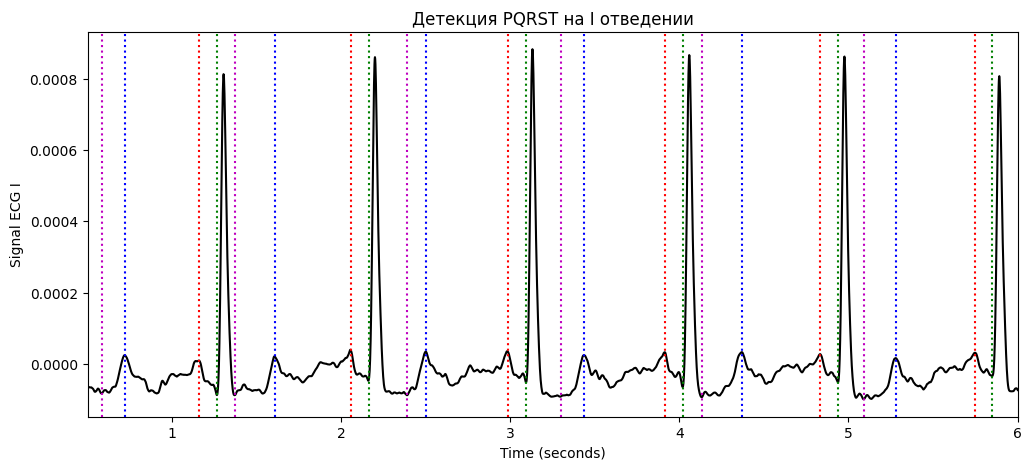

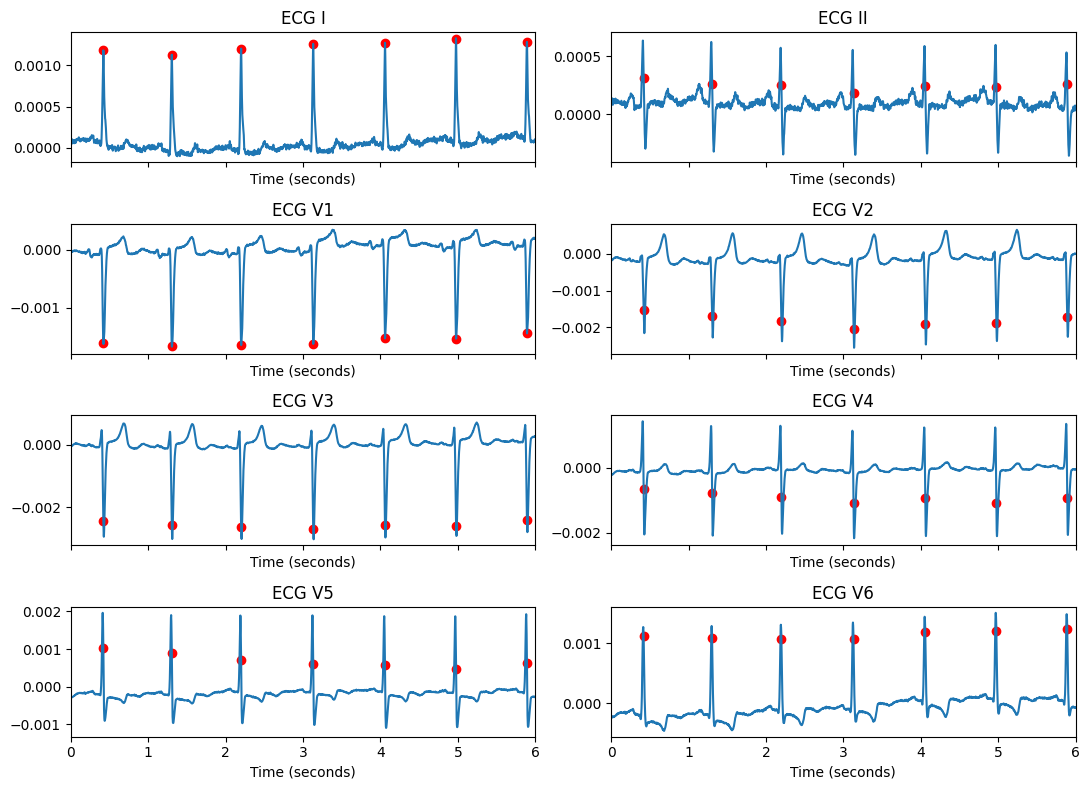

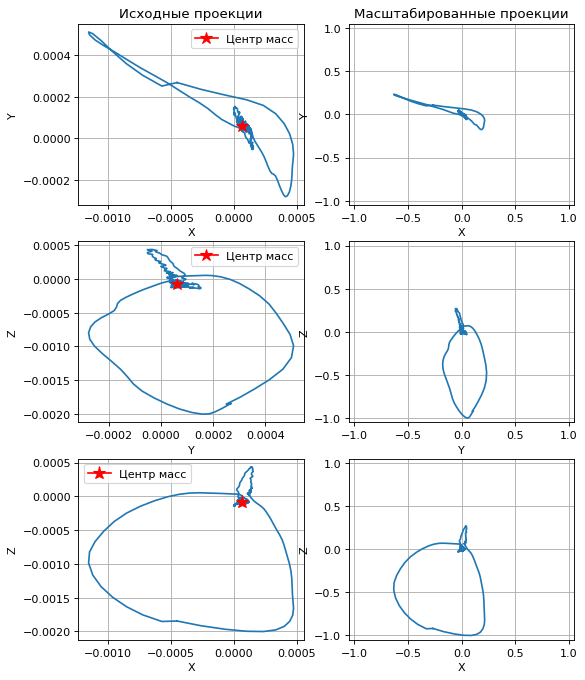

In [6]:
input ={}
input["data_edf"] = '../dataset/EDF EF/00030.edf'
input["n_term_start"] = 3
input["n_term_finish"] = None
input["filt"] = False
input["f_sreza"] = 0.7
input["f_sampling"] = 700
input["show_detected_pqrst"] = True
input["show_ecg"] = True
input["plot_3d"] = True
input["save_images"] = False
input["show_log_scaling"] = True
input["cancel_showing"] = False
input["qrs_loop_area"] = True
input["t_loop_area"] = True
input["show_log_loop_area"] = True
input["count_qrst_angle"] = True
input["show_log_qrst_angle"] = True
input['save_coord']=False
input["mean_filter"] = False
res = processing(input)

In [7]:
res

([1.635910029119542e-07,
  1.1152271270093734e-06,
  2.651012551724906e-06,
  5.8450484858621476e-09,
  2.6548737227808628e-08,
  3.842655708056236e-08],
 111.93932912745862,
 26.468782958008383)